In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
from scipy.signal import savgol_filter

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 219107776'
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=5)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   219107776      0.0
  1 TESS Sector 15 2019   SPOC     120   219107776      0.0
  2 TESS Sector 16 2019   SPOC     120   219107776      0.0
  3 TESS Sector 17 2019   SPOC     120   219107776      0.0
  4 TESS Sector 18 2019   SPOC     120   219107776      0.0


Gaps at times: [1696.38854348]
Gaps at times: [1721.58580465]
Gaps at times: [1748.68724642]
Gaps at times: [1773.58173744]
Gaps at times: [1791.10954097 1800.4581543 ]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704140 entries, 0 to 1704139
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    float64
 1   flux    float64
dtypes: float64(2)
memory usage: 26.0 MB
None
Index         132
time     13633120
flux     13633120
dtype: int64


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

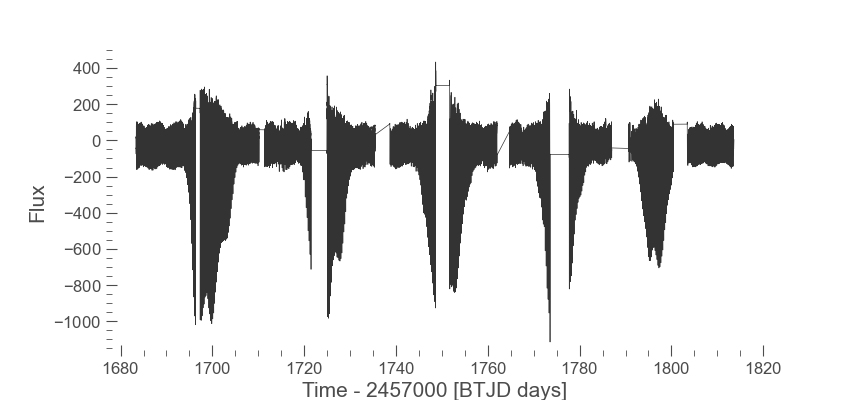

In [3]:
new_lcs = []

for lc in lcs:
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=1500)
    new_lc = straight_lines(new_lc, cadence_magnifier= 20)
    new_lcs.append(new_lc)

lightcurve = combine_lightcurves(new_lcs)
lightcurve.plot()

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

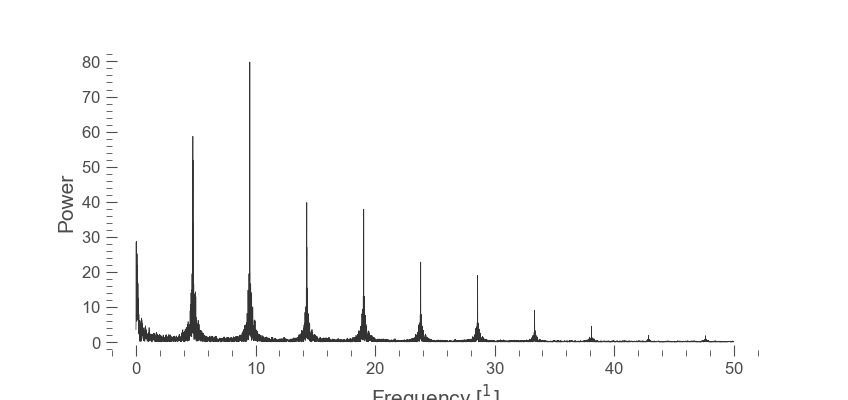

In [4]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 50)
periodogram.plot()

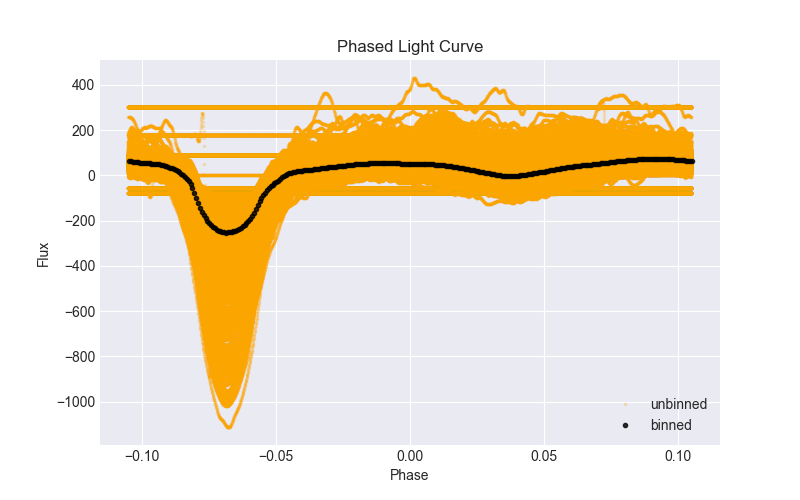

In [10]:
period = 1 / 4.763343500735501


lc_phased = lightcurve.fold(period=period)

lc_phased_binned = lc_phased.bin(1/24/60)

fig, ax = plt.subplots(figsize = (8,5))

lc_phased.plot(ax = ax, marker = '.', linewidth = 0, color = 'orange', alpha = 0.2, markersize = 3, label = 'unbinned')
lc_phased_binned.plot(ax = ax, marker = '.', linewidth = 0, color = 'k', alpha = 0.8, markersize = 6, label = 'binned')

ax.legend()
ax.set_xlabel('Phase')
ax.set_ylabel('Flux')
ax.set_title('Phased Light Curve')
plt.show()

Text(0, 0.5, 'Flux')

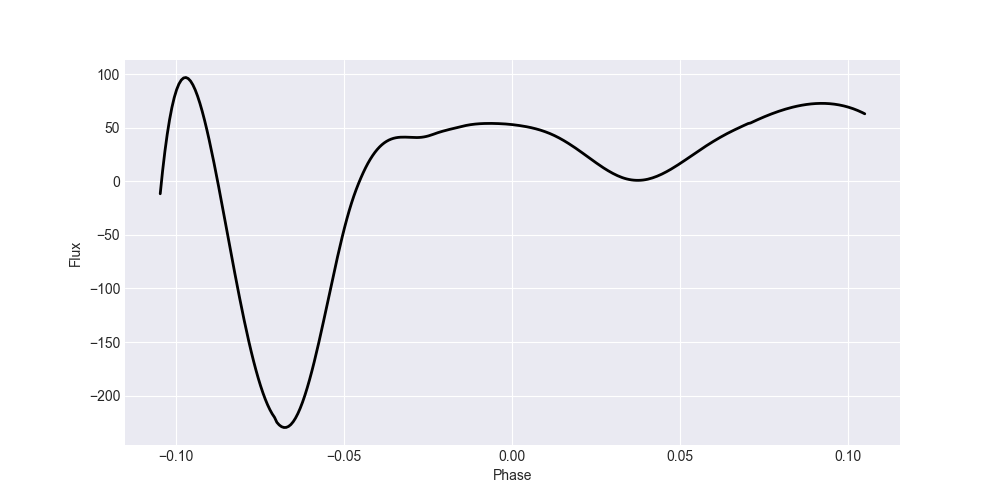

In [38]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

window_length = 100 #The filter uses a window of # data points to fit a polynomial
polyorder = 4      #The filter fits a # degree polynomial to the data points within each window.

lc_binned_smoothed = savgol_filter(lc_phased_binned.flux.value, window_length, polyorder)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(lc_phased_binned.time.value, lc_binned_smoothed, color='k', linewidth=2, label='smoothed')
ax.set_xlabel('Phase')
ax.set_ylabel('Flux')



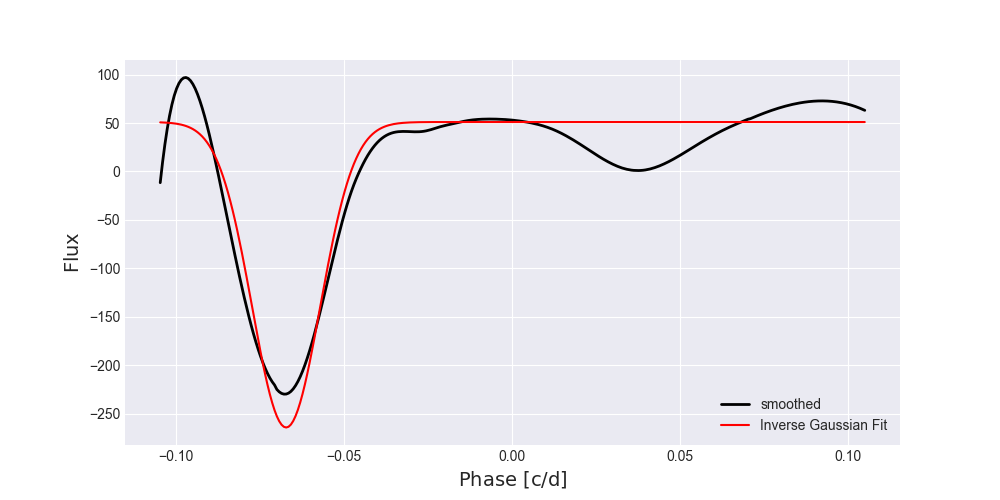

Fitted parameters:
Amplitude: 315.20297604920296
Center: -0.06713622719703624
Standard Deviation: 0.010112590131647321
Width: -0.020225180263294642


In [40]:
from scipy.optimize import curve_fit

def inv_gaussian(x, amp, cen, wid):
    return -(amp * np.exp(-((x - cen)**2) / (2 * wid**2))-1) +50

x = lc_phased_binned.time.value
y = lc_phased_binned.flux.value

mask_valid = ~np.isnan(y) & ~np.isinf(y)
x = x[mask_valid]
y = y[mask_valid]

initial_guess = [-259, -0.067, .0245]  #we need to guess from the folding graph [y of the peak, x of the peak, width from half of the peak]
popt, pcov = curve_fit(inv_gaussian, x, y, p0=initial_guess)

amp_fitted, cen_fitted, wid_fitted = popt

y_fitted = inv_gaussian(x, amp_fitted, cen_fitted, wid_fitted)

fig_LS, ax_LS = plt.subplots(figsize=(10, 5))
ax_LS.plot(lc_phased_binned.time.value, lc_binned_smoothed, color='k', linewidth=2, label='smoothed')
ax_LS.plot(x, y_fitted, 'r-', label='Inverse Gaussian Fit')
ax_LS.set_xlabel(r'${\rm Phase~[c/d]}$', fontsize=14)
ax_LS.set_ylabel(r'${\rm Flux}$', fontsize=14)
ax_LS.legend()
plt.show()

print(f'Fitted parameters:\nAmplitude: {amp_fitted}\nCenter: {cen_fitted}\nStandard Deviation: {wid_fitted}\nWidth: {wid_fitted*(-2)}')


In [25]:
0.0790-0.0545

0.0245